In [1]:
!pip install git+https://github.com/naplab/PyTCI.git
!git clone https://github.com/naplab/PyTCI

  Cloning https://github.com/naplab/PyTCI.git to /tmp/pip-req-build-ny_9uprq
  Running command git clone --filter=blob:none --quiet https://github.com/naplab/PyTCI.git /tmp/pip-req-build-ny_9uprq
  Resolved https://github.com/naplab/PyTCI.git to commit f68c8a5cb27a26e12bd67fe01c97ec394d1e3796
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-many

In [2]:
import tarfile
import os

# Create a folder if it doesn't exist
os.makedirs('/content/Examples/', exist_ok=True)
# Open the tar archive
with tarfile.open('/content/PyTCI/Examples/resources.tar', 'r') as tar:
    # Extract all files to the current directory
    tar.extractall(path='/content/Examples/')


In [3]:
!sudo apt install libsox-dev

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base libsox-fmt-mp3
  libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
Suggested packages:
  libaudio2 libsndio6.1
The following NEW packages will be installed:
  libao-common libao4 libid3tag0 libmad0 libopencore-amrnb0 libopencore-amrwb0
  libsox-dev libsox-fmt-all libsox-fmt-alsa libsox-fmt-ao libsox-fmt-base
  libsox-fmt-mp3 libsox-fmt-oss libsox-fmt-pulse libsox3 libwavpack1
0 upgraded, 16 newly installed, 0 to remove and 45 not upgraded.
Need to get 1,053 kB of archives.
After this operation, 4,061 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libao-common all 1.2.2+20180113-1.1ubuntu3 [6,568 B]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main

# Setup

In [4]:
import os
import numpy as np
import IPython.display as ipd
import matplotlib.pyplot as plt

import torch
import torchaudio

import PyTCI.tci as tci
import PyTCI.audio as fx

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In this example script, we create a mock model that convolves the input waveform by 7 causal filters emulating gamma distribution probability density functions, with different theoretical integration windows specified by the $\text{rate}$ parameter.

Since we know the filters, we can estimate the integration windows directly from the cumulative density function of the gamma distributions. Here, we approximate the integration window by measuring how long it takes for the area under the curve of each filter to reach 90% of its maximum value.

## 1. Create a toy model

Our toy model consists of 5 output channels, each one the result of convolving the input with a causal gamma distributed window, with increasing temporal rates (decreasing temporal widths):

In [5]:
# Expected input sampling rate
in_sr = 16_000

# Different rates for the filter
rates = [10, 5, 2.5, 1.25, 0.625]

# Create filters gamma distributions
weights = []
for rate in rates:
    dist = torch.distributions.gamma.Gamma(2, rate)
    dist = torch.tensor([torch.exp(dist.log_prob(i)) for i in np.arange(1e-7, 10, 5/in_sr)])
    weights.append(dist.flip(0) / sum(dist))
weights = torch.stack(weights, dim=0).unsqueeze(dim=1).to(device).float()

Here we plot the 5 integration windows of the model:

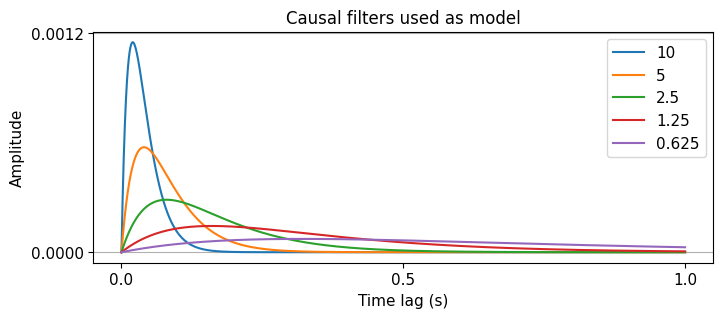

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(np.arange(in_sr)/in_sr, weights.squeeze(1).T.flip(0)[:in_sr].cpu(), linewidth=1.5)
plt.xlabel('Time lag (s)', fontsize=11)
plt.ylabel('Amplitude', fontsize=11)
plt.title('Causal filters used as model', fontsize=12)
plt.xticks([0, 0.5, 1.0], fontsize=11)
plt.yticks([0, 0.0012], fontsize=11)
plt.grid(axis='y')
plt.legend(rates, loc='upper right', fontsize=11)
plt.show()

We create a function that applies each filter defined above to the input and returns a 5-channel output:

In [7]:
def model(x):
    x = torch.as_tensor(x, device=device)
    x = torch.nn.functional.pad(x, (0, 0, weights.shape[-1]-1, 0)).float()
    x = x.T.unsqueeze(dim=0)
    x = torch.nn.functional.conv1d(x, weights, stride=16)
    x = x.squeeze(dim=0).T

    return x

Note that the output sampling rate is 1/16 of the input sampling rate (i.e., 1KHz), due to the stride of 16 in the model.

## 2. Directly measure integration windows

Knowing the exact filters the model applies to the input and since the filters are static, we can directly measure the window of stimulus within which inputs affect the output, and outside of which they have little effect. Here, we approximate this window size by taking the integral of the filters, and finding the smallest time lag $t_I$ such that the integral of the filter for $0 ≤ t ≤ t_I$ is at least 90% of the total integral of the filter. In other words, the area under the filter curve from $0 ≤ t ≤ t_I$ is at least 90% of the total area under the filter curve.

In [8]:
cdf = weights.squeeze(1).cumsum(axis=1).cpu()
intwin_cdf = [(np.where(c.flip(0) >= 0.10)[0][-1])/in_sr+0.001 for c in cdf]

print('Directly estimated integration windows:', [round(_, 3) for _ in intwin_cdf], 'second')

Directly estimated integration windows: [0.079, 0.157, 0.312, 0.623, 1.198] second


# The TCI paradigm

The TCI analysis consists of three main steps:
1. Generating TCI sequence pairs.
2. Inferring the models response to the sequences.
3. Measuring the cross-context correlation of the model responses between the sequence pairs.

## 1. Generate TCI sequence pairs

This step entails extracting segments of a specified duration from a list of source stimuli, here excerpts of speech extracted from the LibriSpeech corpus. Then randomly shuffling the extracted segments and concatenating them (with crossfade) to form a long sequence. We repeat this shuffling-concatenation process twice for a given segment duration to achieve a sequence pair, and repeat the entire process above multiple times for different values of segment durations, to achieve a list of sequence pairs, each corresponding to a segment duration. Sequences should have shape $[time \times channel]$. Check the cells below for audio examples.

First, we load the source stimuli that will be used for analysis:

In [9]:
%cd /content/Examples/

/content/Examples


In [10]:
stimuli, in_sr = tci.load_stimuli('resources/segments-librispeech-1k/', fmt='audio')

ipd.display(ipd.Audio(stimuli[2].T, rate=in_sr))
ipd.display(ipd.Audio(stimuli[10].T, rate=in_sr))

Note that the model output had a sampling rate 1KHz due to the stride:

In [11]:
out_sr = in_sr / 16

We can generate a single sequence from random orderings of 0.5 second segments:

In [ ]:
seq = tci.generate_sequence(stimuli, in_sr, segment_dur=0.5, seed=1)

ipd.display(ipd.Audio(seq[:4*in_sr].T, rate=in_sr))

We can generate a sequence pair from two random orderings of 0.5 second subsegments:

In [ ]:
seq_A, seq_B = tci.generate_sequence_pair(stimuli, in_sr, segment_dur=0.5)

ipd.display(ipd.Audio(seq_A[:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(seq_B[:4*in_sr].T, rate=in_sr))

Finally, we can generate multiple sequence pairs, one for each segment duration from a list of segment durations (as described above), to use in our analysis:

In [12]:
# Default list of segment durations from 20ms to 2.48s
segment_durs = tci.SEGMENT_DURS

# Generate all sequence pairs
sequence_pairs = tci.generate_sequence_pair(stimuli, in_sr, segment_durs)

print('Sequence pair for segment duration of 280ms:')
ipd.display(ipd.Audio(sequence_pairs[10][0][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(sequence_pairs[10][1][:4*in_sr].T, rate=in_sr))

print('Sequence pair for segment duration of 1.72s:')
ipd.display(ipd.Audio(sequence_pairs[20][0][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(sequence_pairs[20][1][:4*in_sr].T, rate=in_sr))

Sequence pair for segment duration of 280ms:


Sequence pair for segment duration of 1.72s:


## 2. Infer model responses

The second step entails getting the model responses to all sequences generated above. Each sequence pair, is a tuple pair of two sequences with shapes $[time \times channel]$. For each sequence in a pair, the model should return a response time-course with shape $[time \times units]$.

In [ ]:
response_pairs = [(model(seq_A), model(seq_B)) for seq_A, seq_B in sequence_pairs]

Since the duration of the generated sequences grow with the number of source stimuli and the segment duration, there is a helper function called `infer_sequence_pair` that takes the model and a sequence pair (or a list of sequence pairs), batches the input stimulus across time into `block_size` second batches, with an overlap of `2*context_size` seconds between two adjacent batches to avoid boundary effects, and runs through the model to get the model responses to each sequence:

In [13]:
response_pairs = tci.infer_sequence_pair(
    model, sequence_pairs, segment_durs, in_sr=in_sr, out_sr=out_sr,
    block_size=48.0, context_size=8.0, device=device
)

Note, that this function needs sampling rate of input and output (model activations) to batch correctly:

## 3. Measure the cross-context correlations

The third step entails rearranging the response sequence to achieve the pre-shuffling order, which we call the segment-aligned responses (SAR), then calculating the correlation between the responses across the two shuffling conditions (across SAR pair) to obtain what we call the cross-context correlation:

In [14]:
SAR_pairs = tci.rearrange_sequence_pair(
    response_pairs, out_sr, segment_durs
)

cross_context_corrs = tci.cross_context_corrs(SAR_pairs)

Finally, now that for each model unit we have a cross-context correlation value per segment duration, we use a correlation threshold to determine the integration window of the model. In other words, we determine the smallest segment duration for which at some point the response of that unit in the two different context conditions achieves the threshold, i.e., becomes invariant to context.

In [15]:
intwin_tci = tci.estimate_integration_window(
    cross_context_corrs, segment_durs, threshold=0.98
)

Now we can compare the integration windows estimated using TCI, with the integration windows estimated directly from the filter kernels:

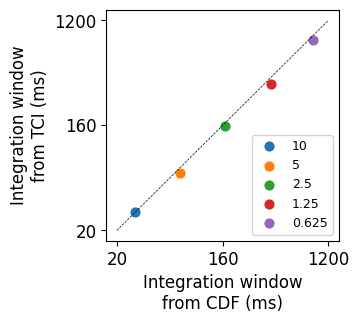

In [16]:
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.06, 1.5]), np.log([0.06, 1.5]), 'k--', linewidth=0.5)
for i, rate in enumerate(rates):
    plt.scatter(np.log(intwin_cdf[i]), np.log(intwin_tci[i]), 40, label=rate)
plt.xticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.legend(loc='lower right', fontsize=9)
plt.show()

As expected, our analysis has identified the proper integration window for each kernel.

# Natural-random vs. random-random

There are two methods for generating a TCI sequence pair, as described in the paper:
1. Random-random: both sequences are created by random ordering of the segments.
2. Natural-random: one sequence is created by having the segments in their natural context (determined by the $\text{natural_dur}$ parameter), while the other is the result of a random ordering like in the previous case.

The default behavior is "random-random". To change the method to "natural-random", set the $\text{comparison_method}$ parameter to $\text{'natural-random'}$, when generating and rearranging sequence pairs.

In [ ]:
# Default list of segment durations from 20ms to 2.48s
segment_durs = tci.SEGMENT_DURS

In [ ]:


# Generate all sequence pairs
sequence_pairs = tci.generate_sequence_pair(stimuli, in_sr, segment_durs, comparison_method='natural-random')

print('Sequence pair for segment duration of 280ms:')
ipd.display(ipd.Audio(sequence_pairs[10][0][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(sequence_pairs[10][1][:4*in_sr].T, rate=in_sr))

print('Sequence pair for segment duration of 1.72s:')
ipd.display(ipd.Audio(sequence_pairs[20][0][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(sequence_pairs[20][1][:4*in_sr].T, rate=in_sr))

response_pairs = tci.infer_sequence_pair(
    model, sequence_pairs, segment_durs, in_sr=in_sr, out_sr=out_sr,
    block_size=48.0, context_size=8.0, device=device
)

SAR_pairs = tci.rearrange_sequence_pair(
    response_pairs, out_sr, segment_durs, comparison_method='natural-random'
)

cross_context_corrs = tci.cross_context_corrs(SAR_pairs)

intwin_tci = tci.estimate_integration_window(
    cross_context_corrs, segment_durs, threshold=0.98
)

Sequence pair for segment duration of 280ms:


Sequence pair for segment duration of 1.72s:


As shown below, the results from both cases are quite similar:

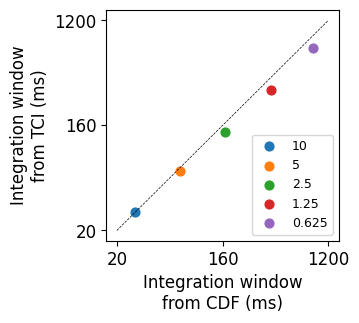

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.06, 1.5]), np.log([0.06, 1.5]), 'k--', linewidth=0.5)
for i, rate in enumerate(rates):
    plt.scatter(np.log(intwin_cdf[i]), np.log(intwin_tci[i]), 40, label=rate)
plt.xticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.legend(loc='lower right', fontsize=9)
plt.show()

# Stimulus manipulation

It is possible to manipulate the source stimuli before generating the TCI sequences, using the $\text{process}$ parameter of $\text{load_segments}$ or $\text{process_segments}$ functions. This is mainly useful in two cases:
1. When loading segments from the disk, but we don't want to make changes to the files on disk.
2. When comparing the effects of specific stimulus manipulations on integration windows of the model.

The $\text{process}$ parameter takes in a function or an ordered list of functions, that will be applied to each stimulus tensor in series. There are a number of basic audio manipulation functions provided in the <a href="https://github.com/naplab/PyTCI/blob/main/PyTCI/audio.py">$\text{audio}$</a> module. This module utilizes the SoX backend of the torchaudio library.

Here are some examples:

### 1. Reverberant:

In [21]:
stimuli_rb, in_sr = tci.load_stimuli(
    'resources/segments-librispeech-1k/',
    process=fx.reverb_fx(reverberance=40, room_scale=70)
)

ipd.display(ipd.Audio(stimuli_rb[2][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(stimuli_rb[10][:4*in_sr].T, rate=in_sr))

In [22]:
sequence_pairs = tci.generate_sequence_pair(stimuli_rb, in_sr, segment_durs)
response_pairs = tci.infer_sequence_pair(
    model, sequence_pairs, segment_durs, in_sr=in_sr, out_sr=out_sr,
    block_size=48.0, context_size=8.0, device=device
)

SAR_pairs = tci.rearrange_sequence_pair(
    response_pairs, out_sr, segment_durs
)

cross_context_corrs = tci.cross_context_corrs(SAR_pairs)

intwin_tci_rb = tci.estimate_integration_window(
    cross_context_corrs, segment_durs, threshold=0.98
)

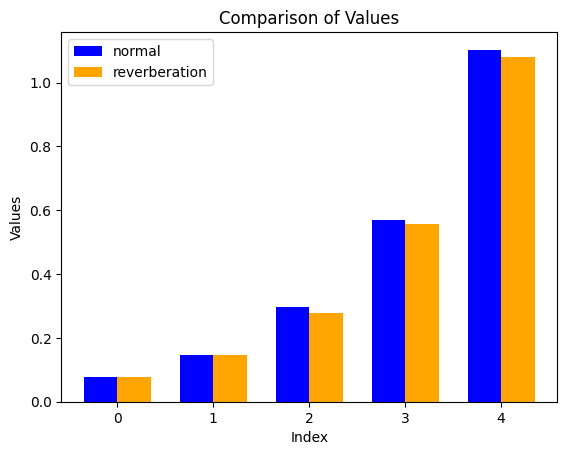

In [26]:
import numpy as np
import matplotlib.pyplot as plt


# Create an array for the x-axis
x = np.arange(len(intwin_tci))

# Width of the bars
width = 0.35

# Plot the bars side by side
plt.bar(x - width/2, intwin_tci, width, label='normal', color='blue')
plt.bar(x + width/2, intwin_tci_rb, width, label='reverberation', color='orange')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Values')
plt.xticks(x, x)  # Set x-axis labels to match the index
plt.legend()  # Show legend

# Show plot

### 2. Sped-up, same pitch:

In [ ]:
stimuli_spedup, in_sr = tci.load_stimuli(
    'resources/segments-librispeech-1k/',
    process=fx.tempo_fx(scale_factor=1.5)
)

ipd.display(ipd.Audio(stimuli_spedup[2][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(stimuli_spedup[10][:4*in_sr].T, rate=in_sr))

In [ ]:
sequence_pairs = tci.generate_sequence_pair(stimuli_spedup, in_sr, segment_durs)
response_pairs = tci.infer_sequence_pair(
    model, sequence_pairs, segment_durs, in_sr=in_sr, out_sr=out_sr,
    block_size=48.0, context_size=8.0, device=device
)

SAR_pairs = tci.rearrange_sequence_pair(
    response_pairs, out_sr, segment_durs
)

cross_context_corrs = tci.cross_context_corrs(SAR_pairs)

intwin_tci_spedup = tci.estimate_integration_window(
    cross_context_corrs, segment_durs, threshold=0.98
)


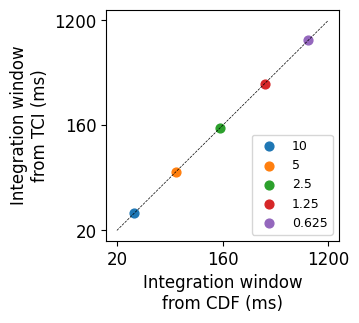

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.06, 1.5]), np.log([0.06, 1.5]), 'k--', linewidth=0.5)
for i, rate in enumerate(rates):
    plt.scatter(np.log(intwin_tci[i]), np.log(intwin_tci_spedup[i]), 40, label=rate)
plt.xticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.legend(loc='lower right', fontsize=9)
plt.show()

### 3. Faster rate:

In [ ]:
stimuli_fast, in_sr = tci.load_stimuli(
    'resources/segments-librispeech-1k/',
    process=fx.speed_fx(scale_factor=1.5)
)

ipd.display(ipd.Audio(stimuli_fast[2][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(stimuli_fast[10][:4*in_sr].T, rate=in_sr))

In [ ]:
sequence_pairs = tci.generate_sequence_pair(stimuli_fast, in_sr, segment_durs)
response_pairs = tci.infer_sequence_pair(
    model, sequence_pairs, segment_durs, in_sr=in_sr, out_sr=out_sr,
    block_size=48.0, context_size=8.0, device=device
)

SAR_pairs = tci.rearrange_sequence_pair(
    response_pairs, out_sr, segment_durs
)

cross_context_corrs = tci.cross_context_corrs(SAR_pairs)

intwin_tci_fast = tci.estimate_integration_window(
    cross_context_corrs, segment_durs, threshold=0.98
)

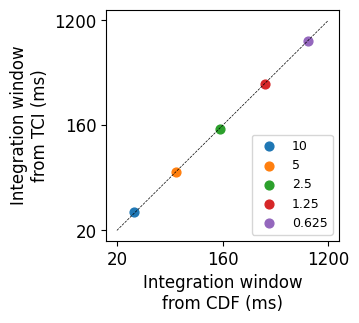

In [ ]:
plt.figure(figsize=(3, 3))
plt.plot(np.log([0.06, 1.5]), np.log([0.06, 1.5]), 'k--', linewidth=0.5)
for i, rate in enumerate(rates):
    plt.scatter(np.log(intwin_tci[i]), np.log(intwin_tci_fast[i]), 40, label=rate)
plt.xticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.yticks(np.log([0.06, 0.3, 1.5]), [20, 160, 1200], fontsize=12)
plt.xlabel('Integration window\nfrom CDF (ms)', fontsize=12)
plt.ylabel('Integration window\nfrom TCI (ms)', fontsize=12)
plt.legend(loc='lower right', fontsize=9)
plt.show()

### 4. Higher pitch:

In [17]:
stimuli_hp, in_sr = tci.load_stimuli(
    'resources/segments-librispeech-1k/',
    process=fx.pitch_fx(300)
)

ipd.display(ipd.Audio(stimuli_hp[2][:4*in_sr].T, rate=in_sr))
ipd.display(ipd.Audio(stimuli_hp[10][:4*in_sr].T, rate=in_sr))

In [18]:
sequence_pairs = tci.generate_sequence_pair(stimuli_hp, in_sr, segment_durs)
response_pairs = tci.infer_sequence_pair(
    model, sequence_pairs, segment_durs, in_sr=in_sr, out_sr=out_sr,
    block_size=48.0, context_size=8.0, device=device
)

SAR_pairs = tci.rearrange_sequence_pair(
    response_pairs, out_sr, segment_durs
)

cross_context_corrs = tci.cross_context_corrs(SAR_pairs)

intwin_tci_hp = tci.estimate_integration_window(
    cross_context_corrs, segment_durs, threshold=0.98
)

In [19]:
intwin_tci_hp

array([0.076, 0.146, 0.294, 0.569, 1.108])

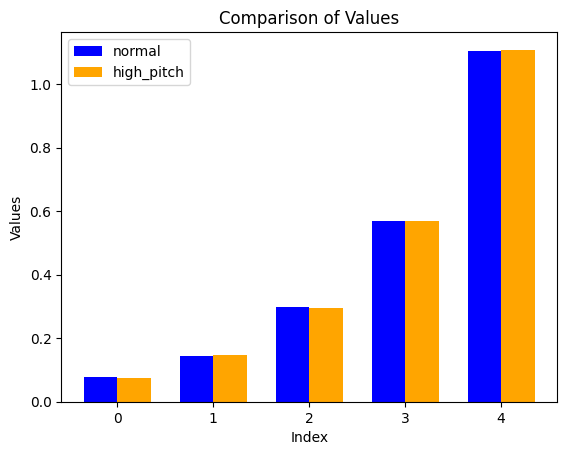

In [20]:
import numpy as np
import matplotlib.pyplot as plt


# Create an array for the x-axis
x = np.arange(len(intwin_tci))

# Width of the bars
width = 0.35

# Plot the bars side by side
plt.bar(x - width/2, intwin_tci, width, label='normal', color='blue')
plt.bar(x + width/2, intwin_tci_hp, width, label='high_pitch', color='orange')

# Add labels and title
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Comparison of Values')
plt.xticks(x, x)  # Set x-axis labels to match the index
plt.legend()  # Show legend

# Show plot
plt.show()


In [ ]:
import torch
import torch.nn as nn

class SimpleFCNetwork(nn.Module):
    def __init__(self):
        super(SimpleFCNetwork, self).__init__()

        self.fc1 = nn.Linear(1, 64)  # Input size: 1, Output size: 64
        self.fc2 = nn.Linear(64, 128)  # Input size: 64, Output size: 128
        self.fc3 = nn.Linear(128, 256)  # Input size: 128, Output size: 256
        self.fc4 = nn.Linear(256, 128)  # Input size: 256, Output size: 128
        self.fc5 = nn.Linear(128, 1)  # Input size: 128, Output size: 1
        self.ops = torch.empty(5,)
    def forward(self, x):

        x1 = torch.relu(self.fc1(x))
        x2 = torch.relu(self.fc2(x))
        x3 = torch.relu(self.fc3(x))
        x4 = torch.relu(self.fc4(x))
        x5 = self.fc5(x)
        self.ops = torch.tensor([x1,x2,x3,x4,x5])
        return x5
    def fetch(self,layer):
        return self.ops[layer]


# Create an instance of the network
model1 = SimpleFCNetwork()
model1.to(device)


SimpleFCNetwork(
  (fc1): Linear(in_features=1, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)

In [ ]:
def estimate_layer_intwin(layer, stimuli, segment_durs, in_sr, out_sr):
    sequence_pairs = tci.generate_sequence_pair(
        stimuli, in_sr, segment_durs
    )

    response_pairs = tci.infer_sequence_pair(
        model1.fetch(layer), sequence_pairs, segment_durs,
        in_sr=in_sr, out_sr=out_sr, block_size=48.0, context_size=8.0, device=device
    )

    SAR_pairs = tci.rearrange_sequence_pair(
        response_pairs, out_sr, segment_durs
    )

    cross_context_corrs = tci.cross_context_corrs(
        SAR_pairs, batch_size=100
    )

    integration_windows = tci.estimate_integration_window(
        cross_context_corrs, segment_durs, threshold=0.75
    )

    return integration_windows